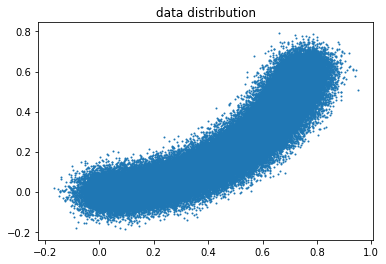

In [57]:
import numpy as np
import torch.nn as nn
import torch.nn.init
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


class CustomDataSet(torch.utils.data.Dataset):

    def __init__(self, n_data):

        self.n_data = n_data
        radius = 0.0
        theta = 0.0
        d_theta = 0.007
        d_radius = 0.01
        self.data = np.random.randn(self.n_data, 2) * 0.05
        n_iter = self.n_data//100
        idx = 0
        for i in range(100):
            pos_x = radius * np.cos(theta)
            pos_y = radius * np.sin(theta)
            for j in range(n_iter):
                self.data[idx][0] += pos_x
                self.data[idx][1] += pos_y
                idx += 1
            radius += d_radius
            theta += d_theta
        self.data = torch.from_numpy(self.data).float()

    def __len__(self):
        return self.n_data

    def __getitem__(self, idx):
        return self.data[idx]


class Encoder(nn.Module):

    def __init__(self):
        super(Encoder, self).__init__()
        self.layer = torch.nn.Sequential(
            torch.nn.Linear(in_features=2, out_features=16, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=16, out_features=16, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=16, out_features=16, bias=True),
            torch.nn.ReLU(),
        )
        self.mean_fc = nn.Linear(in_features=16, out_features=2, bias=True)
        self.pre_stddev_fc = nn.Linear(in_features=16, out_features=2, bias=True)
        self.pre_stddev_active = nn.ELU(alpha=1.0)

    def forward(self, x):
        x = self.layer(x)
        mu = self.mean_fc(x)
        stddev = self.pre_stddev_active(self.pre_stddev_fc(x)) + 1.0
        return mu, stddev


class Decoder(nn.Module):

    def __init__(self):
        super(Decoder, self).__init__()
        self.layer = torch.nn.Sequential(
            torch.nn.Linear(in_features=2, out_features=16, bias=True),
            torch.nn.LeakyReLU(negative_slope=0.1),
            torch.nn.Linear(in_features=16, out_features=16, bias=True),
            torch.nn.LeakyReLU(negative_slope=0.1),
            torch.nn.Linear(in_features=16, out_features=16, bias=True),
        )
        self.mean_fc = nn.Linear(in_features=16, out_features=2, bias=True)
        self.pre_stddev_fc = nn.Linear(in_features=16, out_features=2, bias=True)
        self.pre_stddev_active = nn.ELU(alpha=1.0)

    def forward(self, x):
        x = self.layer(x)
        mu = self.mean_fc(x)
        stddev = self.pre_stddev_active(self.pre_stddev_fc(x)) + 1.0
        return mu, stddev


class DiagGaussianDistribution:

    def __init__(self, length, learning_rate):
        self.length = length
        self.mean = torch.zeros((self.length,), dtype=torch.float, requires_grad=True)
        self.pre_stddev = torch.zeros((self.length,), dtype=torch.float, requires_grad=True)
        self.optimizer = torch.optim.SGD([self.mean, self.pre_stddev], lr=learning_rate)
        self.pre_stddev_active = nn.ELU(alpha=1.0)

    def get_params(self):
        return self.mean, self.pre_stddev_active(self.pre_stddev) + 1.0

    def zero_grad(self):
        self.optimizer.zero_grad()

    def step(self):
        self.optimizer.step()


dataset = CustomDataSet(100000)
batch_size = 32
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
true_data = dataset.data.numpy()
plt.title('data distribution')
plt.scatter(true_data[:, 0], true_data[:, 1], s=1)
plt.show()

In [0]:
def nll_evidence_loss(_mu, _stddev, _target):
    _nll = torch.log(_stddev) + ((_mu - _target) * (_mu - _target))/(2.0 * _stddev * _stddev) + 0.5 * np.log(2.0 *3.141592)
    return _nll.mean()

def kld_loss(_q_mu, _q_sig, _p_mu, _p_sig):
    _loss = torch.log(_p_sig) - torch.log(_q_sig) + ((_q_sig * _q_sig + (_q_mu - _p_mu) * (_q_mu - _p_mu)) / (2.0 * _p_sig * _p_sig)) - 0.5
    return _loss.mean()

def true_reg_loss(_q_mu, _q_sig, _eps, _p_mu, _p_sig):
    _loss = torch.log(_p_sig) - torch.log(_q_sig) - 0.5 * _eps * _eps + (_q_sig * _eps + _q_mu - _p_mu) * (_q_sig * _eps + _q_mu - _p_mu) / (2.0 * _p_sig * _p_sig)
    return _loss.mean()

$q_{\phi}(z \vert x) = N(\mu_q, \sigma_{q}^{2}I)$

$p(z) = N(\mu_p, \sigma_{p}^{2}I)$

kld_loss = $D_{KL}(q_{\phi}(z \vert x) \vert \vert p(z)) = \log(\frac{\sigma_p}{\sigma_q}) + \frac{\sigma_q^{2} + (\mu_q - \mu_p)^{2}}{2 \sigma_{p}^{2}} - \frac{1}{2}$

true_reg_loss = $\log(\frac{q_{\phi}(z \vert x)}{p(z)}) =  \log(\frac{\sigma_p}{\sigma_q}) - \frac{\epsilon^{2}}{2} + \frac{(\sigma_q \epsilon + \mu_q - \mu_p)^{2}}{2 \sigma_{p}^{2}}$ 

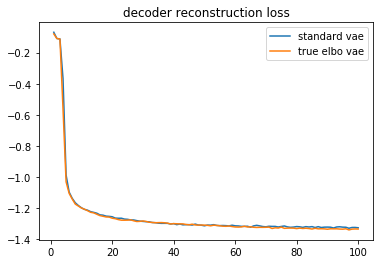

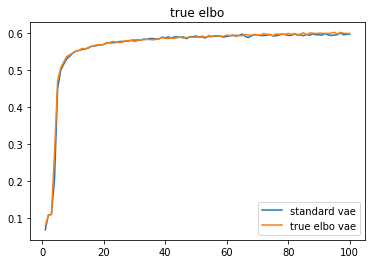

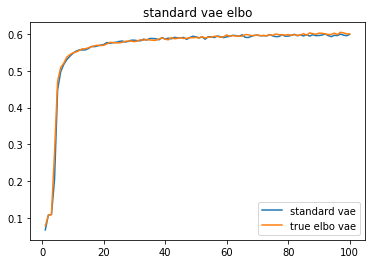

In [59]:
a_encoder = Encoder()
a_decoder = Decoder()
a_prior = DiagGaussianDistribution(2, learning_rate=0.01)
a_e_optimizer = torch.optim.SGD(a_encoder.parameters(), lr=0.01)
a_d_optimizer = torch.optim.SGD(a_decoder.parameters(), lr=0.01)
a_recon_loss = []
a_true_elbo = []
a_standard_elbo = []

num_epoch = 100
num_batch = len(loader)
for epoch in range(num_epoch):
    avg_nll = 0.0
    avg_true_reg = 0.0
    avg_standard_kld = 0.0
    for batch_index, mini_batch_data in enumerate(loader):
        q_mu, q_sig = a_encoder(mini_batch_data)
        p_mu, p_sig = a_prior.get_params()
        eps = torch.FloatTensor(q_sig.size()).normal_()
        kld = kld_loss(q_mu, q_sig, p_mu, p_sig)
        x_mu, x_sig = a_decoder(q_sig * eps + q_mu)
        recon_loss = nll_evidence_loss(x_mu, x_sig, mini_batch_data)
        loss = recon_loss + kld
        a_prior.zero_grad()
        a_e_optimizer.zero_grad()
        a_d_optimizer.zero_grad()
        loss.backward()
        a_e_optimizer.step()
        a_d_optimizer.step()
        a_prior.step()
        avg_nll += recon_loss.item()
        avg_standard_kld += kld.item()
        avg_true_reg += true_reg_loss(q_mu, q_sig, eps, p_mu, p_sig).item()
    a_recon_loss.append(avg_nll / num_batch)
    a_standard_elbo.append(-(avg_nll + avg_standard_kld) / num_batch)
    a_true_elbo.append(-(avg_nll + avg_true_reg) / num_batch)


b_encoder = Encoder()
b_decoder = Decoder()
b_prior = DiagGaussianDistribution(2, learning_rate=0.01)
b_e_optimizer = torch.optim.SGD(b_encoder.parameters(), lr=0.01)
b_d_optimizer = torch.optim.SGD(b_decoder.parameters(), lr=0.01)
b_recon_loss = []
b_true_elbo = []
b_standard_elbo = []
for epoch in range(num_epoch):
    avg_nll = 0.0
    avg_true_reg = 0.0
    avg_standard_kld = 0.0
    for batch_index, mini_batch_data in enumerate(loader):
        q_mu, q_sig = b_encoder(mini_batch_data)
        p_mu, p_sig = b_prior.get_params()
        eps = torch.FloatTensor(q_sig.size()).normal_()
        kld = true_reg_loss(q_mu, q_sig, eps, p_mu, p_sig)
        x_mu, x_sig = b_decoder(q_sig * eps + q_mu)
        recon_loss = nll_evidence_loss(x_mu, x_sig, mini_batch_data)
        loss = recon_loss + kld
        b_prior.zero_grad()
        b_e_optimizer.zero_grad()
        b_d_optimizer.zero_grad()
        loss.backward()
        b_e_optimizer.step()
        b_d_optimizer.step()
        b_prior.step()
        avg_nll += recon_loss.item()
        avg_standard_kld += kld_loss(q_mu, q_sig, p_mu, p_sig).item()
        avg_true_reg += kld.item()
    b_recon_loss.append(avg_nll / num_batch)
    b_standard_elbo.append(-(avg_nll + avg_standard_kld) / num_batch)
    b_true_elbo.append(-(avg_nll + avg_true_reg) / num_batch)


plt.title('decoder reconstruction loss')
plt.plot(np.arange(1, num_epoch + 1), a_recon_loss, label='standard vae')
plt.plot(np.arange(1, num_epoch + 1), b_recon_loss, label='true elbo vae')
plt.legend()
plt.show()

plt.title('true elbo')
plt.plot(np.arange(1, num_epoch + 1), a_true_elbo, label='standard vae')
plt.plot(np.arange(1, num_epoch + 1), b_true_elbo, label='true elbo vae')
plt.legend()
plt.show()

plt.title('standard vae elbo')
plt.plot(np.arange(1, num_epoch + 1), a_standard_elbo, label='standard vae')
plt.plot(np.arange(1, num_epoch + 1), b_standard_elbo, label='true elbo vae')
plt.legend()
plt.show()

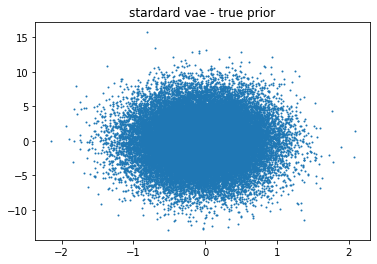

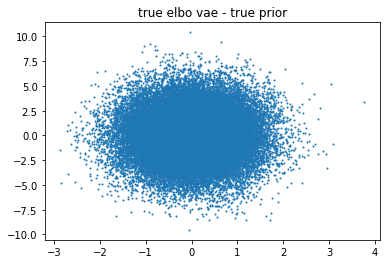

In [60]:
def gaussian_sampling(_mu, _stddev):
    _eps = torch.FloatTensor(_stddev.size()).normal_()
    return _stddev * _eps + _mu

prior_mean, prior_stddev = a_prior.get_params()
true_prior_sample = (prior_stddev * torch.randn(40000, 2) + prior_mean).data.numpy()
plt.title('stardard vae - true prior')
plt.scatter(true_prior_sample[:, 0], true_prior_sample[:, 1], s=1)
plt.show()

prior_mean, prior_stddev = b_prior.get_params()
true_prior_sample = (prior_stddev * torch.randn(40000, 2) + prior_mean).data.numpy()
plt.title('true elbo vae - true prior')
plt.scatter(true_prior_sample[:, 0], true_prior_sample[:, 1], s=1)
plt.show()

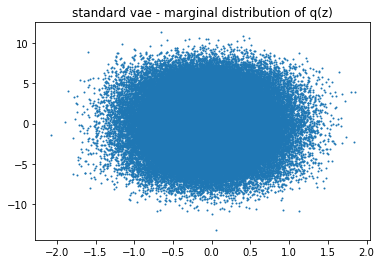

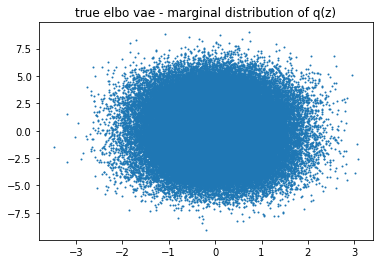

In [61]:
a_z_mu, a_z_sig = a_encoder(torch.FloatTensor(dataset.data))
a_z_sample = gaussian_sampling(a_z_mu, a_z_sig)
a_x_mu, a_x_sig = a_decoder(a_z_sample)

b_z_mu, b_z_sig = b_encoder(torch.FloatTensor(dataset.data))
b_z_sample = gaussian_sampling(b_z_mu, b_z_sig)
b_x_mu, b_x_sig = b_decoder(b_z_sample)

plt.title('standard vae - marginal distribution of q(z)')
plt.scatter(a_z_sample.data.numpy()[:, 0], a_z_sample.data.numpy()[:, 1], s=1)
plt.show()

plt.title('true elbo vae - marginal distribution of q(z)')
plt.scatter(b_z_sample.data.numpy()[:, 0], b_z_sample.data.numpy()[:, 1], s=1)
plt.show()

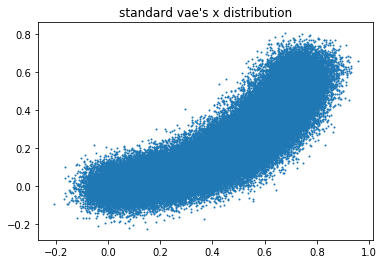

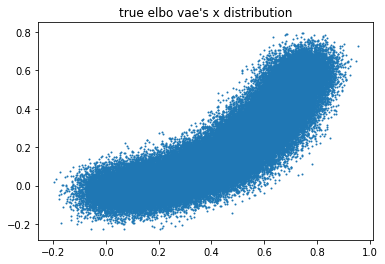

In [62]:
a_x_sample = gaussian_sampling(a_x_mu, a_x_sig).data.numpy()
plt.title('standard vae\'s x distribution')
plt.scatter(a_x_sample[:, 0], a_x_sample[:, 1], s=1)
plt.show()
b_x_sample = gaussian_sampling(b_x_mu, b_x_sig).data.numpy()
plt.title('true elbo vae\'s x distribution')
plt.scatter(b_x_sample[:, 0], b_x_sample[:, 1], s=1)
plt.show()